# Part 2: Transfer Learning

In [ ]:
#Import Packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN,TextVectorization
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling1D
from keras.regularizers import l2
from keras import utils as np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

import random
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/nclarke12/deep_learning_assignment

Cloning into 'deep_learning_assignment'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 59 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), 48.63 MiB | 5.71 MiB/s, done.


In [ ]:
from keras.models import load_model
import tensorflow_hub as hub
swivel_model = load_model('/content/deep_learning_assignment/swivel_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
cnn_lstm_model = load_model('/content/deep_learning_assignment/cnn_lstm_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})


In [ ]:
swivel_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_12 (Dense)            (None, 64)                1344      
                                                                 
 dense_13 (Dense)            (None, 30)                1950      
                                                                 
Total params: 403,314
Trainable params: 403,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           20608     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                      

In [ ]:
#Reading in and printing details of dataset
bbc=pd.read_csv('/content/deep_learning_assignment/bbc-text.csv')
print(bbc.shape)
bbc.head()

#unique_values(bbc)

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
#Create number of categories
section_count_bbc = 5

#Mapping Section Names to Integers as Category ID
bbc["category"] = bbc["category"].astype('category')
bbc["category_id"] = bbc["category"].cat.codes
bbc.head()

id_to_category = pd.Series(bbc.category.values,index=bbc.category_id).to_dict()
id_to_category

{4: 'tech', 0: 'business', 3: 'sport', 1: 'entertainment', 2: 'politics'}

In [ ]:
bbc.groupby("category").count()["text"].reset_index().sort_values("text", ascending = False)

,category,text
3,sport,511
0,business,510
2,politics,417
4,tech,401
1,entertainment,386


In [ ]:
np.save('/content/drive/MyDrive/Deep_Learning_Models/id_to_category_pt2.npy', id_to_category)

In [ ]:
#Creating Train, Validation and Test Sets
train_bbc, validate_bbc, test_bbc = np.split(bbc.sample(frac=1, random_state=42), [int(.8*len(bbc)), int(.9*len(bbc))])
print(train_bbc.shape)
print(validate_bbc.shape)
print(test_bbc.shape)

#Splitting out datasets
x_train_bbc = train_bbc.text
y_train_bbc = train_bbc.category_id
x_val_bbc = validate_bbc.text
y_val_bbc = validate_bbc.category_id
x_test_bbc = test_bbc.text
y_test_bbc = test_bbc.category_id

(1780, 3)
(222, 3)
(223, 3)


In [ ]:
#Define hyperparameters
max_words = 27000
max_len = 100


#Create Tokenizer
tokenizer_bbc = Tokenizer(num_words=max_words)
tokenizer_bbc.fit_on_texts(x_train_bbc)

#Tokenise all texts
x_train_bbc = tokenizer_bbc.texts_to_sequences(x_train_bbc)
x_val_bbc = tokenizer_bbc.texts_to_sequences(x_val_bbc)
x_test_bbc = tokenizer_bbc.texts_to_sequences(x_test_bbc)

#Padding Arrays
x_train_bbc = sequence.pad_sequences(x_train_bbc, maxlen=max_len)
x_val_bbc = sequence.pad_sequences(x_val_bbc, maxlen=max_len)
x_test_bbc = sequence.pad_sequences(x_test_bbc, maxlen=max_len)

# One-hot encode the labels
y_train_bbc = to_categorical(y_train_bbc)
y_test_bbc = to_categorical(y_test_bbc)
y_val_bbc = to_categorical(y_val_bbc)

#Create Vocab
vocab_bbc = tokenizer_bbc.word_index
print('Found %s unique tokens.' % len(vocab_bbc))

Found 27035 unique tokens.


In [ ]:
#Saving test data to google drive to access later
np.save('/content/drive/MyDrive/Deep_Learning_Models/x_test_pt2.npy', x_test_bbc)
np.save('/content/drive/MyDrive/Deep_Learning_Models/y_test_pt2.npy', y_test_bbc)
np.save('/content/drive/MyDrive/Deep_Learning_Models/x_test_bbc_text.npy', test_bbc["text"])


In [ ]:
#Function to graph accuracy and validation accuracy

def display_training_history(training_history):
    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']
    plt.title('Model Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training Data')
    plt.plot(val_accuracy, label='Validation Data')
    plt.legend()
    plt.show()



In [ ]:
#Transfer learning CNN model to BBC data 


#Taking the layers that we want to 'transfer'/use to BBC dataset
base_inputs = cnn_lstm_model.layers[0].input 
#Taking the second last layer which would be our dense_6 since we have a different number of categories in the BBC dataset
base_outputs = cnn_lstm_model.layers[-2].output
#Specifying what we actually want as our final layer to use in the BBC dataset 
last_outputs = layers.Dense(5)(base_outputs)

model_cnn_bbc = tf.keras.Model(inputs = base_inputs,outputs = last_outputs)
model_cnn_bbc.trainable = False
model_cnn_bbc.summary()

model_cnn_bbc.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Fit Model to BBC data
history = model_cnn_bbc.fit(x_train_bbc, y_train_bbc,
          batch_size=32,
          epochs=20,
          validation_data=(x_test_bbc, y_test_bbc))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4_input (InputLay  [(None, 100)]            0         
 er)                                                             
                                                                 
 embedding_4 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           20608     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

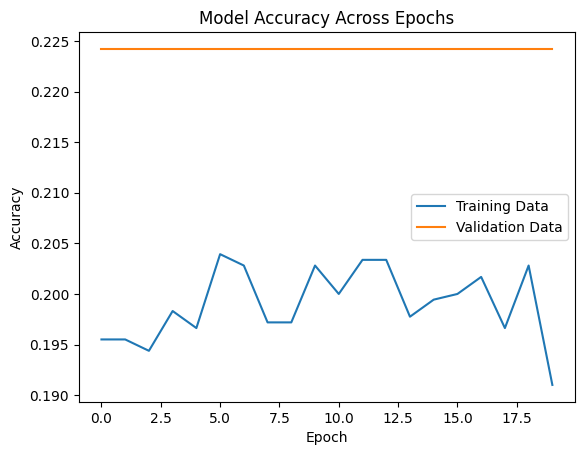

In [ ]:
display_training_history(history)

In [ ]:
#Taking the layers that we want to 'transfer'/use to BBC dataset
base_inputs = swivel_model.layers[0].input 
#Taking the second last layer which would be our dense_6 since we have a different number of categories in the BBC dataset
base_outputs = swivel_model.layers[-2].output
#Specifying what we actually want as our final layer to use in the BBC dataset 
last_outputs = layers.Dense(5)(base_outputs)

model_swivel_bbc = tf.keras.Model(inputs = base_inputs,outputs = last_outputs )
model_swivel_bbc.trainable = False
model_swivel_bbc.summary()

model_swivel_bbc.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Fit Model to BBC data
history = model_swivel_bbc.fit(train_bbc["text"], y_train_bbc,
          batch_size=32,
          epochs=20,
          validation_data=(test_bbc["text"], y_test_bbc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_input (InputLay  [(None,)]                0         
 er)                                                             
                                                                 
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_12 (Dense)            (None, 64)                1344      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 401,689
Trainable params: 0
Non-trainable params: 401,689
_________________________________________________________________
Epoch 1/20
56/56 [==============================] - 6s 27ms/step - loss: 7.2443 - accuracy: 0.3056 - val_loss: 7.1319 - v

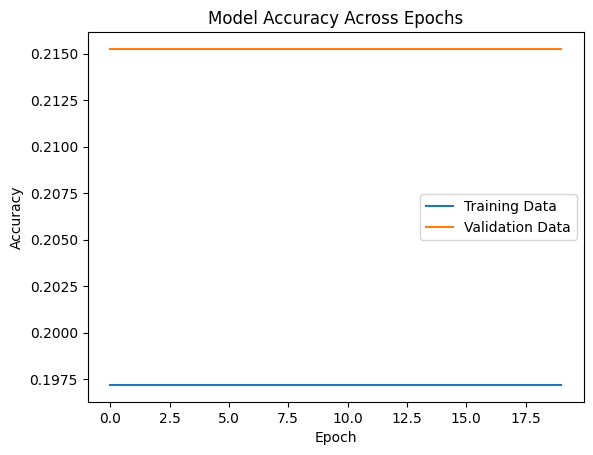

In [ ]:
display_training_history(history)

In [ ]:
#Adding the pretrained CNN LSTM model as a layer

epochs = 20

model_cnn_bbc_pretrain_layer = Sequential()

#
model_cnn_bbc_pretrain_layer.add(model_cnn_bbc)
model_cnn_bbc_pretrain_layer.add(Dropout(0.3))
model_cnn_bbc_pretrain_layer.add(Dense(128, activation='tanh'))
model_cnn_bbc_pretrain_layer.add(Dense(5,activation="softmax"))

model_cnn_bbc_pretrain_layer.summary()


model_cnn_bbc_pretrain_layer.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_cnn_bbc_pretrain_layer.fit(x_train_bbc, y_train_bbc,
          batch_size=32,
          epochs=epochs,
          validation_data=(x_test_bbc, y_test_bbc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5)                 1120773   
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 128)               768       
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,122,186
Trainable params: 1,413
Non-trainable params: 1,120,773
_________________________________________________________________
Epoch 1/20
56/56 [==============================] - 3s 14ms/step - loss: 1.6134 - accuracy: 0.2326 - val_loss: 1.5844 - val_accuracy: 0.2915
Epoch 2/20
56/56 [===============

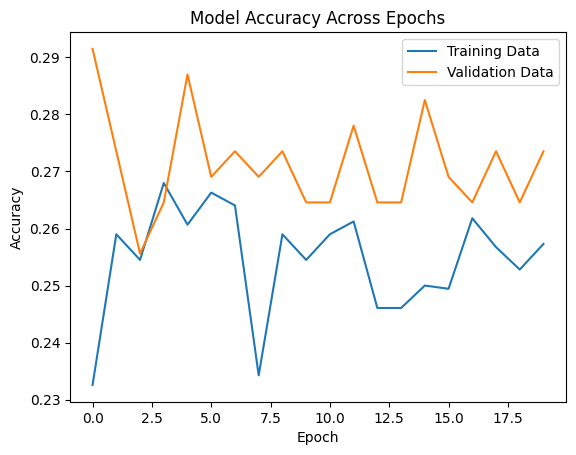

In [ ]:
display_training_history(history)

In [ ]:
#Adding the pretrained Swivel model as a layer

epochs = 10

model_swivel_bbc_pretrain_layer = Sequential()

#
model_swivel_bbc_pretrain_layer.add(model_swivel_bbc)
model_swivel_bbc_pretrain_layer.add(Dropout(0.3))
model_swivel_bbc_pretrain_layer.add(Dense(128, activation='tanh'))
model_swivel_bbc_pretrain_layer.add(Dense(5,activation="softmax"))

model_swivel_bbc_pretrain_layer.summary()


model_swivel_bbc_pretrain_layer.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_swivel_bbc_pretrain_layer.fit(train_bbc["text"], y_train_bbc,
          batch_size=32,
          epochs=epochs,
          
          validation_data=(test_bbc["text"], y_test_bbc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5)                 401689    
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 128)               768       
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 403,102
Trainable params: 1,413
Non-trainable params: 401,689
_________________________________________________________________
Epoch 1/10
56/56 [==============================] - 2s 9ms/step - loss: 1.2271 - accuracy: 0.5326 - val_loss: 0.9725 - val_accuracy: 0.6592
Epoch 2/10
56/56 [====================

In [ ]:


model_swivel_bbc_pretrain_layer.save('model_swivel_bbc_pretrain_layer.h5')
shutil.copy("model_swivel_bbc_pretrain_layer.h5", "/content/drive/MyDrive/Deep_Learning_Models/model_swivel_bbc_pretrain_layer.h5")

'/content/drive/MyDrive/Deep_Learning_Models/model_swivel_bbc_pretrain_layer.h5'

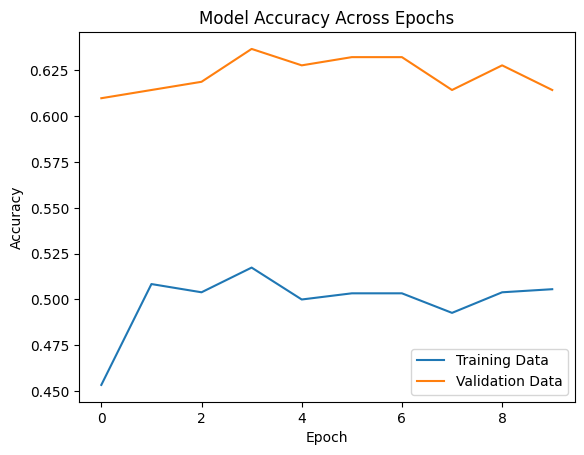

In [ ]:
display_training_history(history)

**Building models from scratch**

In [ ]:


callback = [
    EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)
]


In [ ]:
#Buidling a CNN with LSTM layers training on BBC data to compare preformance with pre-trained model. Trying the same as the above model to check outputs

embedding_dims = 32
epochs = 20

model_scratch_1 = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
model_scratch_1.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
model_scratch_1.add(Conv1D(32, 5, activation='relu'))
model_scratch_1.add(MaxPooling1D(3))
model_scratch_1.add(LSTM(embedding_dims))
model_scratch_1.add(Dropout(0.3))
model_scratch_1.add(Dense(128, activation='tanh'))
model_scratch_1.add(Dense(5,activation="softmax"))
model_scratch_1.summary()


model_scratch_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_scratch_1.fit(x_train_bbc, y_train_bbc,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test_bbc, y_test_bbc))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           864000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            5152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_scratch_1.save('model_scratch_1.h5')
shutil.copy("model_scratch_1.h5", "/content/drive/MyDrive/Deep_Learning_Models/model_scratch_1.h5")

Mounted at /content/drive


In [ ]:
model_scratch_1.save('model_scratch_1.h5')
shutil.copy("model_scratch_1.h5", "/content/drive/MyDrive/Deep_Learning_Models/model_scratch_1.h5")

'/content/drive/MyDrive/Deep_Learning_Models/model_scratch_1.h5'

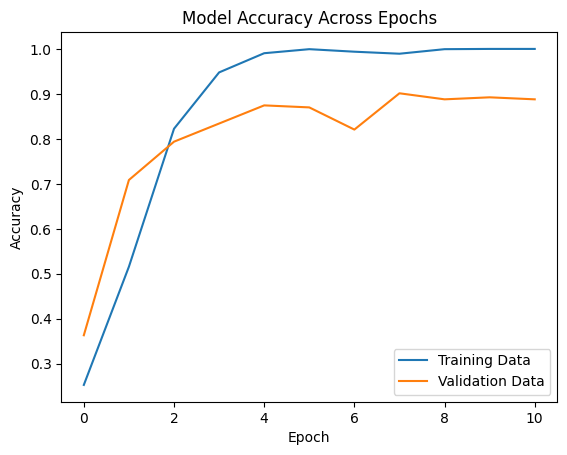

In [ ]:
display_training_history(history)

In [ ]:
#Lets try using Swivel to see it preforms better as we saw in part 1 

import tensorflow_hub as hub

print("loading embedding")
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], trainable = True, dtype=tf.string)


loading embedding


In [ ]:
# Creating the pretrained embedding layer using Swivel
from tensorflow.keras import initializers

# Embedding model
epochs = 20

model_scratch_2 = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
model_scratch_2.add(hub_layer)
model_scratch_2.add(Dense(64, activation='tanh'))
model_scratch_2.add(Dense(5, activation='softmax'))

model_scratch_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_scratch_2.summary()

history = model_scratch_2.fit(train_bbc["text"], y_train_bbc,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(test_bbc["text"], y_test_bbc))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_8 (Dense)             (None, 64)                1344      
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 401,689
Trainable params: 401,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
56/56 [==============================] - 14s 237ms/step - loss: 1.0049 - accuracy: 0.6253 - val_loss: 0.5056 - val_accuracy: 0.8789
Epoch 2/20
56/56 [==============================] - 10s 188ms/step - loss: 0.4559 - accuracy: 0.8534 - val_loss: 0.3158 - val_accuracy: 0.9193
Epoch 3/20
56/56 [========

In [ ]:
model_scratch_2.save('model_scratch_2.h5')
shutil.copy("model_scratch_2.h5", "/content/drive/MyDrive/Deep_Learning_Models/model_scratch_2.h5")

'/content/drive/MyDrive/Deep_Learning_Models/model_scratch_2.h5'

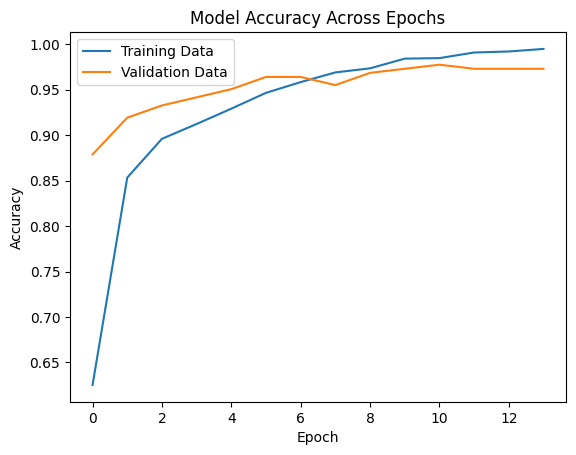

In [ ]:
display_training_history(history)